In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [174]:
from typing import Annotated
from typing_extensions import TypedDict, Dict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

In [175]:
class State(TypedDict):
    # 메시지 목록
    messages: Annotated[list, add_messages]
    # 사람에게 질문할지 여부를 묻는 상태 추가
    ask_human: bool

In [4]:
from pydantic import BaseModel


class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

In [180]:
class Location(TypedDict):
    """사용자에게 지역을 입력받고, 몇박 몇일 여행할지 입력받고,
    여행 인원이 총 몇명인지 입력받고 네이버 지역 api tool에 연결 해준다.
    """
    messages: Annotated[list, add_messages]
    location: str
    travel_days: str
    travel_num: int

# 사용자 입력 데이터 스키마 정의
class UserInput(BaseModel):
    user_input: str
    config: Dict[str, Dict[str, str]]

from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage
import json

# LLM 모델 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 프롬프트 템플릿 정의
prompt_template = PromptTemplate(
    input_variables=["user_input"],
    template="""
    사용자의 입력에서 지역, 여행 기간(며칠), 그리고 인원을 추출하세요.
    응답 형식은 JSON으로 제공하세요:
    {{
        "location": "<지역>",
        "travel_days": "<며칠>",
        "travel_num": <인원 수>
    }}
    사용자 입력: {user_input}
    """
)
state = StateGraph(Location)

def dummy(state:Location):
    """초기 입력값 설정"""
    return {"messages": []}

def extract_location(user_input: str)-> Location:
    """LLM을 이용해 사용자 입력에서 Location 정보를 추출"""
    prompt = prompt_template.format(user_input=user_input)
    response = llm.invoke(prompt)  # LLM으로부터 응답 받기

    return {"messages": [response]}

# async def run_workflow(user_input: str, config: dict):
#     # graph.invoke 실행
#     result = await graph.invoke({"messages": user_input}, config, stream_mode="values")
#     return result


# state = Location(location="서울", travel_days="1박2일", travel_num=3)


# workflow = StateGraph(Location)

# process(state)

In [182]:

# 상태를 처리하는 함수 정의
def process(state: Location):
    print(f"{state.location}에서 {state.travel_days} 동안 {state.travel_num}명이 여행합니다.")



# 노드 추가: 사용자 입력을 받아 상태 생성
def input_processing(state: Location):
    return extract_location(user_input)

# 노드 추가: 상태를 처리
def process_location(state: Location) -> Location:
    print(f"state: {state}")
    print(type(state))

    response = [item.content for item in state["messages"] if isinstance(item, AIMessage)

    ]
    
    print(f"response:{response}")

    # print(type(response[0].content))
    # res = response[0].content
    print(type(response))
    print(type(response[0]))

    if response:  # 응답이 비어 있지 않을 경우
        clean_content = response[0].strip("```json").strip("```").strip()  # JSON 문자열 추출
        parsed_data = json.loads(clean_content)  # JSON 파싱
        print(f"parsed_data: {parsed_data}")
        return {
            "location": parsed_data["location"],
            "travel_days": parsed_data["travel_days"],
            "travel_num": parsed_data["travel_num"]
        }       
    
    return input_processing



# LangGraph 워크플로우 정의
workflow = StateGraph(Location)


workflow.add_node("dummy", dummy)
workflow.add_node("input_processing", input_processing)
workflow.add_node("process_location", process_location)

# 두 노드를 연결
workflow.add_edge(START, "dummy")
workflow.add_edge("dummy", "input_processing" )
workflow.add_edge("input_processing", "process_location")
# workflow.add_edge("input_processing", END)
workflow.add_edge("process_location", END)

graph = workflow.compile()

user_input = input("지역, 일정, 인원을 입력해주세요 (서울 1박2일 3명)")

config = {"configurable": {"thread_id": "2"}}
# 워크플로우 실행
graph.invoke({"messages": user_input} ,config, stream_mode="values")
# print(graph)

state: {'messages': [HumanMessage(content='서울 1박2일 3명', additional_kwargs={}, response_metadata={}, id='c34d7af3-bd7b-4a9f-8fb8-dfdab7fa3fc9'), AIMessage(content='```json\n{\n    "location": "서울",\n    "travel_days": "1박2일",\n    "travel_num": 3\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 84, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-338713b7-4b9d-415b-8174-ee0cf8972d3b-0', usage_metadata={'input_tokens': 84, 'output_tokens': 33, 'total_tokens': 117, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
<class 'dict'>
response:['```json\n{\n

{'messages': [HumanMessage(content='서울 1박2일 3명', additional_kwargs={}, response_metadata={}, id='c34d7af3-bd7b-4a9f-8fb8-dfdab7fa3fc9'),
  AIMessage(content='```json\n{\n    "location": "서울",\n    "travel_days": "1박2일",\n    "travel_num": 3\n}\n```', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 84, 'total_tokens': 117, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-338713b7-4b9d-415b-8174-ee0cf8972d3b-0', usage_metadata={'input_tokens': 84, 'output_tokens': 33, 'total_tokens': 117, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'location': '서울',
 'travel_days': '1박2일',


In [10]:
tools = [Location]

llm = ChatOpenAI(model="gpt-4o-mini", temperatur=0)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])


    # 메시지와 ask_human 상태 반환
    return {"messages": [response]}



d:\pythonSrc\tourGuide\backend\venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: UserWarning: WARNING! temperatur is not default parameter.
                temperatur was transferred to model_kwargs.
                Please confirm that temperatur is what you intended.
  if await self.run_code(code, result, async_=asy):


In [11]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[Location]))

In [12]:


# 도구 추가
tool = TavilySearch(max_results=3)

# 도구 목록 추가(HumanRequest 도구)
tools = [tool, HumanRequest]

# LLM 추가
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest' 인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 반환
    return {"messages": [response], "ask_human": ask_human}

In [18]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    # select_next_node,
    {"tools": "tools", END: END},
)

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # # 'human' 이전에 인터럽트 설정
    # interrupt_before=["tools"],
)

from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

In [9]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 인간 노드 처리
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }


# 그래프에 인간 노드 추가
graph_builder.add_node("human", human_node)

In [10]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [11]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)

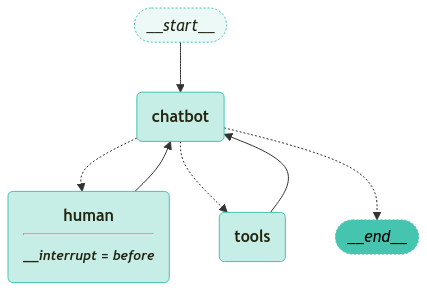

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [13]:
# user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 검색해서 답변하세요" (Human 이 아닌 웹검색을 수행하는 경우)
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "1"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_tX8urjjT1I55ASlz8R6P83Jq)
 Call ID: call_tX8urjjT1I55ASlz8R6P83Jq
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.


In [14]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next

('human',)

In [15]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efdabba-6201-6f13-8002-b37d8d041429'}}

In [16]:
# 그래프 상태에서 메시지 값 가져오기
graph.get_state(config).values["messages"]

[HumanMessage(content='이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?', additional_kwargs={}, response_metadata={}, id='d780bd8f-45bb-41fb-993d-30760dbedea1'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tX8urjjT1I55ASlz8R6P83Jq', 'function': {'arguments': '{"request":"AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다."}', 'name': 'HumanRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 171, 'total_tokens': 202, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-da0a0350-3ff9-43c9-9650-72440c302151-0', tool_calls=[{'name': 'HumanRequest', 'args': {'request': 'AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.'}, 'id': 'call_

In [17]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청했습니다. LangGraph를 확인해 보시기를 추천드립니다. 이 플랫폼은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.


In [18]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_tX8urjjT1I55ASlz8R6P83Jq)
 Call ID: call_tX8urjjT1I55ASlz8R6P83Jq
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청했습니다. LangGraph를 확인해 보시기를 추천드립니다. 이 플랫폼은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.
